In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


test images

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import pickle
from matplotlib import pyplot as plt


In [ ]:
# Charger le modèle TFLite
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/waste_classifier7.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Charger le label encoder
with open("/content/drive/MyDrive/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


In [ ]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Impossible de lire l'image : {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_preprocessed = img_resized.astype(np.float32)
    img_preprocessed = img_preprocessed / 127.5 - 1.0  # preprocess_input

    input_data = np.expand_dims(img_preprocessed, axis=0)

    # Envoyer à TFLite
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]

    pred_index = np.argmax(output_data)
    confidence = output_data[pred_index] * 100
    predicted_label = label_encoder.inverse_transform([pred_index])[0]

    # Affichage
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label} ({confidence:.1f}%)")
    plt.show()


In [ ]:
!ls /content/drive/MyDrive/test_camera


1.jpg  2.jpg  3.jpg  4.jpg  5.jpg


🖼️ Image : 4.jpg


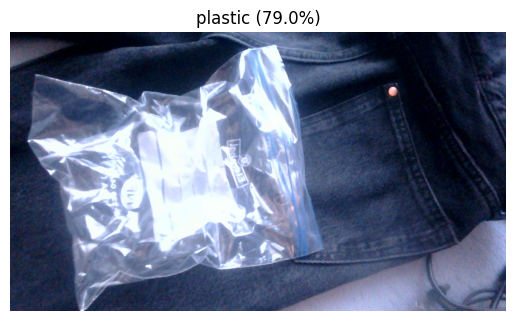

🖼️ Image : 2.jpg


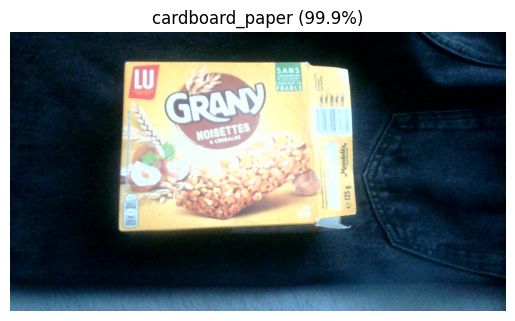

🖼️ Image : 3.jpg


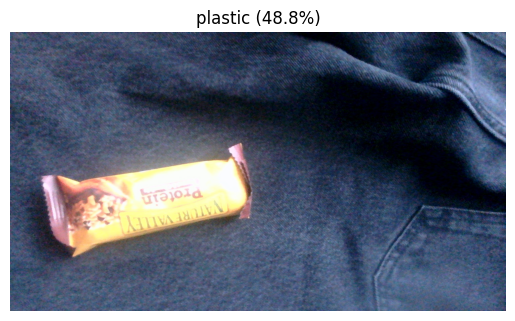

🖼️ Image : 5.jpg


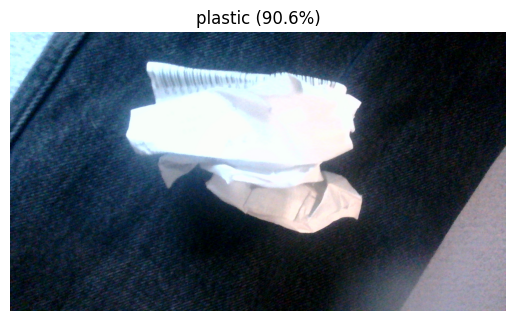

🖼️ Image : 1.jpg


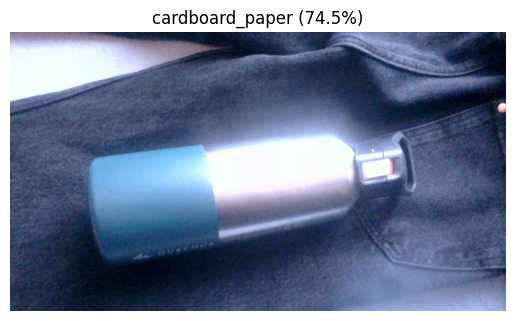

In [ ]:
test_dir = "/content/drive/MyDrive/test_camera"

for filename in os.listdir(test_dir):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        print(f"🖼️ Image : {filename}")
        predict_image(os.path.join(test_dir, filename))


test plus images

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import pickle
import os

image_dir = "/content/drive/MyDrive/dataset_binGo/"
image_size = (224, 224)
batch_size = 32

# Création des datasets bruts
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="int"
)

raw_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="int"
)

# Récupération des noms de classes
class_names = raw_train_dataset.class_names

# Encodage des classes
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

with open("/content/drive/MyDrive/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Preprocessing MobileNetV2
train_dataset = raw_train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = raw_val_dataset.map(lambda x, y: (preprocess_input(x), y))


Found 14286 files belonging to 5 classes.
Using 11429 files for training.
Found 14286 files belonging to 5 classes.
Using 2857 files for validation.


In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.utils import class_weight

# ⚡ On ne récupère que les labels sans charger les images
label_only_ds = raw_train_dataset.map(lambda x, y: y)

y_train_labels = []
for batch_labels in tqdm(label_only_ds, desc="📥 Récupération rapide des labels"):
    y_train_labels.extend(batch_labels.numpy())

# Calcul des poids de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("⚖️ Poids de classes :", class_weights_dict)


📥 Récupération rapide des labels: 100%|██████████| 358/358 [35:04<00:00,  5.88s/it]

⚖️ Poids de classes : {0: np.float64(1.1992654774396643), 1: np.float64(0.794508168230796), 2: np.float64(0.8397501836884643), 3: np.float64(0.9730949340144742), 4: np.float64(1.4513015873015873)}


In [ ]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    weights='imagenet'
)
base_model.trainable = False  # Freeze les couches convolutives

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,078,725 (11.74 MB)

 Trainable params: 820,741 (3.13 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights_dict
)


Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.7109 - loss: 0.7542 - val_accuracy: 0.8600 - val_loss: 0.3924
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 72s 200ms/step - accuracy: 0.8715 - loss: 0.3548 - val_accuracy: 0.8551 - val_loss: 0.3875
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 77s 216ms/step - accuracy: 0.8992 - loss: 0.2720 - val_accuracy: 0.8869 - val_loss: 0.3398
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 83s 219ms/step - accuracy: 0.9205 - loss: 0.2049 - val_accuracy: 0.8995 - val_loss: 0.2993
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 76s 213ms/step - accuracy: 0.9362 - loss: 0.1719 - val_accuracy: 0.8890 - val_loss: 0.3965
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 73s 204ms/step - accuracy: 0.9444 - loss: 0.1531 - val_accuracy: 0.9069 - val_loss: 0.3337
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 71s 198ms/step - accuracy: 0.9606 - loss: 0.1058 - val_accuracy: 0.9132 - val_loss: 0.3676
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - accuracy: 0.9614 - loss: 0.1

In [ ]:
# Prédire les classes pour val_dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

from sklearn.metrics import classification_report, accuracy_score
print("✅ Accuracy :", accuracy_score(y_true, y_pred) * 100, "%")
print("📊 Classification report:\n", classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/content/drive/MyDrive/waste_classifier10.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Modèle TFLite sauvegardé")


Saved artifact at '/tmp/tmpyx2_1erb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_321')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132982055730064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132981920301712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132981920302288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132982055730448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132981920301328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132981920303440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132981920303824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132981920304208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132981920304016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132981920301136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1329819203